<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/Day_Trading_Tesla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [242]:
!pip  install yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf


In [243]:
# ✅ Download most recent 1-hour stock data (Max available: last 720 days)
df = yf.download("TSLA", period="720d", interval="1h")

# ✅ Print actual column names to check the structure
print("Original column names:", df.columns)

[*********************100%***********************]  1 of 1 completed

Original column names: MultiIndex([( 'Close', 'TSLA'),
            (  'High', 'TSLA'),
            (   'Low', 'TSLA'),
            (  'Open', 'TSLA'),
            ('Volume', 'TSLA')],
           names=['Price', 'Ticker'])


In [244]:
# ✅ Fix Multi-Index Columns: Extract only the first level (Price Type)
df.columns = df.columns.get_level_values(0)  # Extract 'Close', 'High', 'Low', 'Open', 'Volume'

# ✅ Reset index to make "Datetime" a column
df = df.reset_index()


In [245]:
# ✅ Keep only relevant columns
df = df[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']]

# ✅ Verify DataFrame
print(df.head())

Price                  Datetime        Open        High         Low  \
0     2022-04-04 13:30:00+00:00  363.000000  369.500000  357.510010   
1     2022-04-04 14:30:00+00:00  369.369995  378.369995  368.336700   
2     2022-04-04 15:30:00+00:00  377.830353  378.911652  375.766693   
3     2022-04-04 16:30:00+00:00  377.533356  381.463348  376.709991   
4     2022-04-04 17:30:00+00:00  381.352783  382.680023  379.833344   

Price       Close   Volume  
0      369.333344  7974058  
1      377.793335  5958949  
2      377.484619  2522470  
3      381.397430  2016766  
4      382.065826  2885778  


In [246]:
print(df.dtypes)  # Ensure Datetime is correctly formatted
df['Datetime'] = pd.to_datetime(df['Datetime'])  # Convert if necessary

Price
Datetime    datetime64[ns, UTC]
Open                    float64
High                    float64
Low                     float64
Close                   float64
Volume                    int64
dtype: object


In [247]:
# ✅ Calculate ATR (Average True Range) for Dynamic Stop-Loss
df['High-Low'] = df['High'] - df['Low']
df['High-Close'] = abs(df['High'] - df['Close'].shift(1))
df['Low-Close'] = abs(df['Low'] - df['Close'].shift(1))
df['True_Range'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
df['ATR'] = df['True_Range'].rolling(window=14).mean()
df.drop(columns=['High-Low', 'High-Close', 'Low-Close', 'True_Range'], inplace=True)  # Clean up

# ✅ Set Dynamic Stop-Loss and Take-Profit
df['Stop_Loss'] = df['Close'] - (1.2 * df['ATR'])  # Tighter SL
df['Take_Profit'] = df['Close'] + (2.0 * df['ATR'])  # Wider TP


# ==========================
# 📌 Exponential Moving Averages (EMA)
# ==========================
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()

# ==========================
# 📌 MACD Calculation (Momentum Indicator)
# ==========================
df['MACD_Line'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
df['MACD_Signal'] = df['MACD_Line'].ewm(span=9, adjust=False).mean()

In [248]:
# ==========================
# 📌 RSI Calculation (Overbought/Oversold)
# ==========================
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

In [249]:
# ==========================
# 📌 ADX Calculation (Trend Strength)
# ==========================
df['+DM'] = np.where((df['High'].diff() > df['Low'].diff()) & (df['High'].diff() > 0), df['High'].diff(), 0)
df['-DM'] = np.where((df['Low'].diff() > df['High'].diff()) & (df['Low'].diff() > 0), df['Low'].diff(), 0)
df['+DI'] = 100 * df['+DM'].rolling(window=14).mean() / df['ATR']
df['-DI'] = 100 * df['-DM'].rolling(window=14).mean() / df['ATR']
df['ADX'] = abs(df['+DI'] - df['-DI']).rolling(window=14).mean()
df.drop(columns=['+DM', '-DM', '+DI', '-DI'], inplace=True)  # Clean up

In [250]:
# ==========================
# 📌 Volume-Based Confirmation
# ==========================
df['Volume_Avg'] = df['Volume'].rolling(20).mean()

# ==========================
# 📌 Buy Signal Conditions
# ==========================
df['Buy_Signal'] = (
    (df['RSI'] < 60) &  # Allow more trades
    (df['EMA_10'] > df['EMA_50']) &
    ((df['MACD_Line'] > df['MACD_Signal']) | (df['MACD_Line'].diff() > 0)) &
    (df['Volume'] > (0.4 * df['Volume_Avg'])) &  # Reduce volume filter
    (df['ADX'] > 18)  # Looser ADX requirement
)
# 📌 Final Tighter Trailing Stop
df['Trailing_Stop'] = np.minimum(
    df['Close'] * 0.985,          # 2% below price
    df['Close'] - (df['ATR'] * 0.3)  # Tighter ATR stop
)


print(df[['Datetime', 'Close', 'ATR', 'Trailing_Stop']].describe())
print(df[df['Close'] < df['Trailing_Stop']].head(10))


# ==========================
# 📌 Sell Signal Conditions
# ==========================
df['Sell_Signal'] = (
    ((df['EMA_10'] < df['EMA_50']) & (df['RSI'] > 60)) |
    ((df['MACD_Line'] < df['MACD_Signal']) & (df['RSI'] > 65)) |
    (df['Close'] < df['Trailing_Stop']) |
    ((df['Volume'] > 0.5 * df['Volume_Avg']) & (df['ADX'] > 20))  # Volume & Trend Filter
)

df['Exit_Signal'] = (
    (df['MACD_Line'].diff() < 0) &  # Ensure MACD is **declining**, not just below signal
    (df['RSI'] > 70) &  # Reduce frequent exits
    (df['Close'] < df['Trailing_Stop'])  # Confirm strong drop
)


# ✅ Ensure MACD Histogram is Calculated
df['MACD_Hist'] = df['MACD_Line'] - df['MACD_Signal']


# ✅ Implement Trailing Stop for Smarter Exits
df['Sell_Signal_Debug'] = (
    ((df['MACD_Hist'] < 0.5) | (df['MACD_Line'] < df['MACD_Signal'])) &  # Weaker MACD threshold
    (df['RSI'] < 55) &  # RSI drop below 55 signals trend weakness
    (df['ADX'] > 15) &  # Moderate trend strength allowed
    ((df['Close'] < df['Trailing_Stop']) | (df['EMA_10'] < df['EMA_50'])) &  # Trailing stop or EMA crossover
    (df['Volume'] > 0.5 * df['Volume_Avg'])  # Volume confirmation
)


# ✅ Debugging: Check why no sell signals (for Debug Version)
sell_signals = df[df['Sell_Signal_Debug']]
print(f"🔍 Number of Debug Sell Signals: {sell_signals.shape[0]}")
print(sell_signals[['Datetime', 'Close', 'RSI', 'MACD_Hist', 'Trailing_Stop']].head(10))

# ✅ Check Individual Conditions for Debug

print("\n🔹 Condition 1: MACD Histogram")
print(f"MACD Histogram < 0.5 Count: {sum(df['MACD_Hist'] < 0.5)}")

print("\n🔹 Condition 2: RSI >= 50")
print(f"RSI >= 50 Count: {sum(df['RSI'] >= 50)}")

print("\n🔹 Condition 3: Close < Trailing_Stop")
crossed_stop = df['Close'] < df['Trailing_Stop']
print(f"Close < Trailing_Stop Count: {sum(crossed_stop)}")

# ================================================
# ✅ Compare Original vs. Debug Sell Signals
# ================================================
print(f"\n⚠️ Original Sell Signals in Data: {df['Sell_Signal'].sum()}")
print(f"⚠️ Debug Sell Signals in Data: {df['Sell_Signal_Debug'].sum()}")

# ================================================
# ✅ Final Debugging Outputs: Sell Signal Statistics
# ================================================

print("Sell Signal Debug Statistics:")
print(df[['Datetime', 'Close', 'Trailing_Stop', 'Sell_Signal_Debug']].describe())

print("\n🔍 Sell Signal Debug Instances:")
print(df[df['Sell_Signal_Debug']].head(10))

print("\n🚀 Total Buy Signals:", df['Buy_Signal'].sum())
print("🚀 Total Sell Signals:", df['Sell_Signal'].sum())
print("🚀 Total Debug Sell Signals:", df['Sell_Signal_Debug'].sum())



Price        Close          ATR  Trailing_Stop
count  5016.000000  5003.000000    5003.000000
mean    236.715986     3.867035     232.813983
std      65.611994     1.690430      64.341939
min     105.669998     1.368093     104.084948
25%     187.762493     2.700037     184.823633
50%     228.284050     3.420156     224.708055
75%     262.338760     4.506187     258.039474
max     480.244995    14.954062     473.041320
Empty DataFrame
Columns: [Datetime, Open, High, Low, Close, Volume, ATR, Stop_Loss, Take_Profit, EMA_10, EMA_50, MACD_Line, MACD_Signal, RSI, ADX, Volume_Avg, Buy_Signal, Trailing_Stop]
Index: []
🔍 Number of Debug Sell Signals: 163
Price                  Datetime       Close        RSI  MACD_Hist  \
98    2022-04-25 13:30:00+00:00  333.886658  23.649332  -0.688784   
99    2022-04-25 14:30:00+00:00  332.690002  27.421493  -0.811517   
100   2022-04-25 15:30:00+00:00  332.062286  30.955009  -0.889125   
103   2022-04-25 18:30:00+00:00  330.188324  36.876838  -0.770986   


In [251]:
# ✅ Risk 2% of portfolio per trade
initial_balance = 10000
risk_per_trade = 0.03 * initial_balance

# ✅ Adjust position size dynamically based on ATR
df['Position_Size'] = np.where(df['ATR'].notna(), risk_per_trade / df['ATR'], np.nan)
df.dropna(subset=['ATR', 'RSI', 'ADX', 'Position_Size', 'Trailing_Stop'], inplace=True)

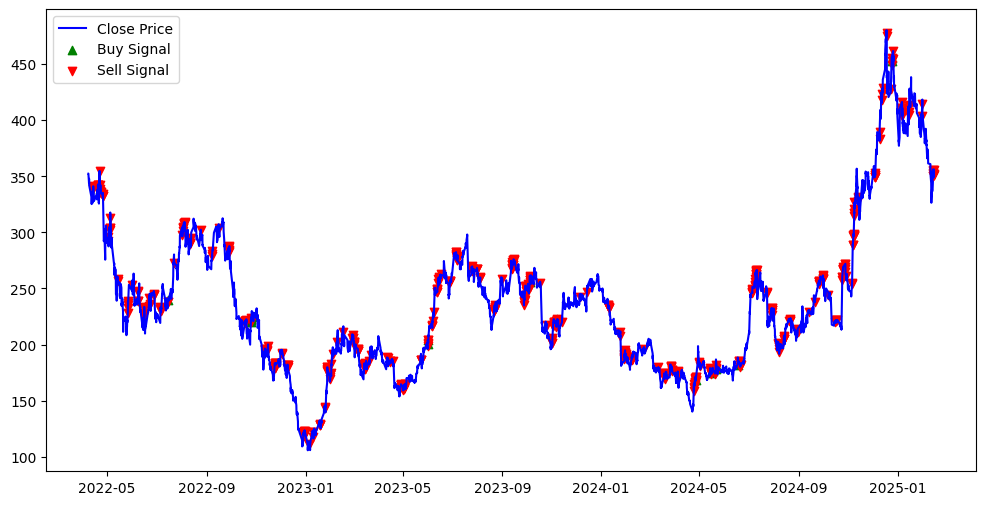

In [252]:
# ✅ Plot Buy/Sell Signals
plt.figure(figsize=(12,6))
plt.plot(df['Datetime'], df['Close'], label='Close Price', color='blue')
plt.scatter(df[df['Buy_Signal']]['Datetime'], df[df['Buy_Signal']]['Close'], marker='^', color='green', label='Buy Signal')
plt.scatter(df[df['Sell_Signal']]['Datetime'], df[df['Sell_Signal']]['Close'], marker='v', color='red', label='Sell Signal')
plt.legend()
plt.show()

In [253]:
# ✅ Initialize capital and trade log
capital = initial_balance
shares = 0
trade_log = []
STOP_LOSS_PERCENT = 0.90  # Stop-Loss at 10% drop
TAKE_PROFIT_PERCENT = 1.05  # Take-Profit at 10% gain
buy_price = None
last_trade_index = -5  # To prevent overtrading

# 📌 Improved Trade Execution with Automatic Stop-Loss & Take-Profit
for i in range(len(df)):
    price = df['Close'].iloc[i]

    # ✅ Buy Condition
    if df['Buy_Signal'].iloc[i] and capital >= price:
        shares = capital // price
        capital -= shares * price
        buy_price = price
        trade_log.append(f"BUY at {price:.2f}")

    # ✅ Sell Conditions
    elif shares > 0:
        if price <= buy_price * STOP_LOSS_PERCENT:  # Stop-Loss (1st Priority)
            capital += shares * price
            trade_log.append(f"SELL (Stop-Loss) at {price:.2f}")
            shares = 0
        elif price < df['Trailing_Stop'].iloc[i]:  # Trailing Stop (2nd Priority)
            capital += shares * price
            trade_log.append(f"SELL (Trailing Stop) at {price:.2f}")
            shares = 0
        elif price >= buy_price * TAKE_PROFIT_PERCENT:  # Take-Profit (3rd Priority)
            capital += shares * price
            trade_log.append(f"SELL (Take-Profit) at {price:.2f}")
            shares = 0
        elif df['Sell_Signal_Debug'].iloc[i]:  # Debug Signal (4th Priority)
            capital += shares * price
            trade_log.append(f"SELL (Debug Signal) at {price:.2f}")
            shares = 0


# ✅ Final Sell If Holding Any Shares
if shares > 0:
    capital += shares * df['Close'].iloc[-1]
    trade_log.append(f"FINAL SELL at {df['Close'].iloc[-1]:.2f}")

# ✅ Compute Performance Metrics
profit_trades = sum([1 for i in range(1, len(trade_log), 2) if float(trade_log[i].split(" at ")[1]) > float(trade_log[i-1].split(" at ")[1])])
total_trades = len(trade_log) // 2
win_rate = (profit_trades / total_trades) * 100 if total_trades > 0 else 0

# ✅ Print Final Performance
print(f"Final Portfolio Value: ${capital:.2f}")
print(f"Profit/Loss: ${capital - initial_balance:.2f}")
print(f"New Win Rate: {win_rate:.2f}%")
print(f"Trade Log: {trade_log}")


Final Portfolio Value: $13394.44
Profit/Loss: $3394.44
New Win Rate: 63.64%
Trade Log: ['BUY at 336.36', 'SELL (Debug Signal) at 333.89', 'BUY at 239.40', 'SELL (Take-Profit) at 260.77', 'BUY at 220.42', 'SELL (Take-Profit) at 232.25', 'BUY at 200.50', 'SELL (Take-Profit) at 213.73', 'BUY at 255.94', 'SELL (Debug Signal) at 242.79', 'BUY at 221.97', 'SELL (Take-Profit) at 233.99', 'BUY at 168.40', 'SELL (Take-Profit) at 185.61', 'BUY at 174.73', 'SELL (Debug Signal) at 174.36', 'BUY at 176.17', 'SELL (Take-Profit) at 186.69', 'BUY at 181.97', 'SELL (Take-Profit) at 192.18', 'BUY at 452.68', 'SELL (Stop-Loss) at 405.97']


In [254]:
print(f"Total Buy Signals: {df['Buy_Signal'].sum()}")
print(f"Total Sell Signals: {df['Sell_Signal'].sum()}")


Total Buy Signals: 26
Total Sell Signals: 605


In [255]:
print("Sell Signals in Data:", df['Sell_Signal'].sum())
print("Total Sell Transactions in Trade Log:", sum(1 for trade in trade_log if "SELL" in trade))


Sell Signals in Data: 605
Total Sell Transactions in Trade Log: 11
